In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# load data
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('train set shape', data.shape)
print('test set shape', test.shape)

train set shape (8693, 14)
test set shape (4277, 13)


In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Feature descriptions
- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
# missing values
print('Train set missing values:')
print(data.isna().sum())
print()
print('Test set missing values:')
print(test.isna().sum())

Train set missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Test set missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [6]:
# number of unique values
data.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [7]:
# data types
data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
# class distribution
data.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [9]:
# look at numeric and categorial values separately
data_num = data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
data_cat = data[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']]

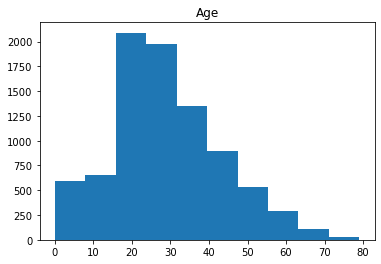

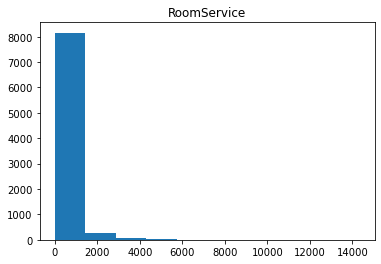

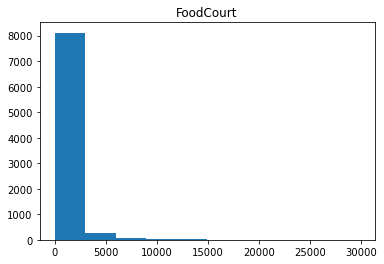

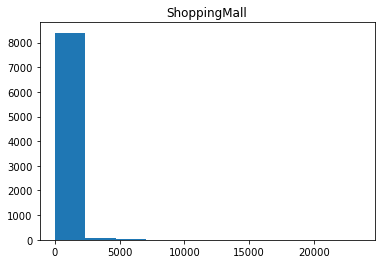

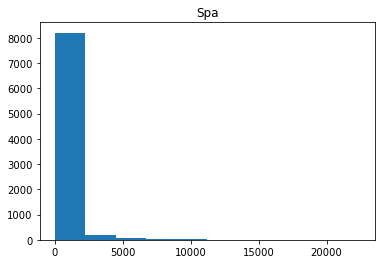

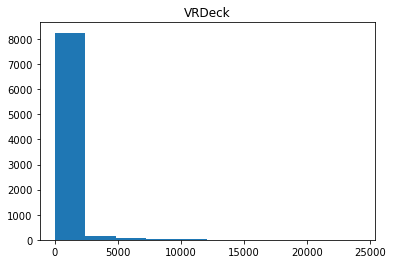

In [10]:
# distributions for all numeric variables
for col in data_num.columns:
    plt.hist(data_num[col])
    plt.title(col)
    plt.show()

                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   

                VRDeck  
Age           0.101007  
RoomService  -0.019581  
FoodCourt     0.227995  
ShoppingMall -0.007322  
Spa           0.153821  
VRDeck        1.000000  


<AxesSubplot:>

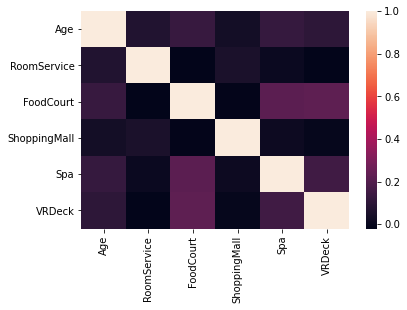

In [11]:
# check correlarion
print(data_num.corr())
sns.heatmap(data_num.corr())

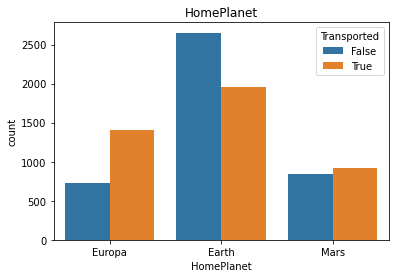

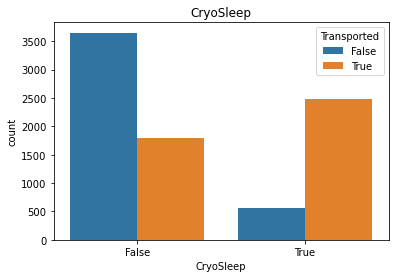

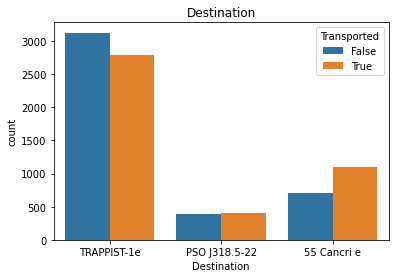

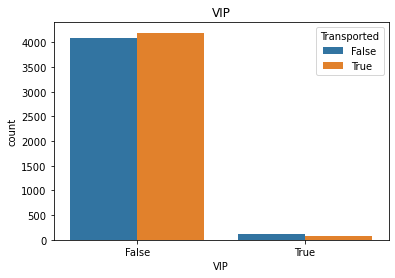

In [12]:
# categorial features
for col in data_cat.columns:
    sns.countplot(data=data, x=col, hue='Transported').set_title(col)
    plt.show()

In [13]:
# transform last features into more useful
data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)
test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)

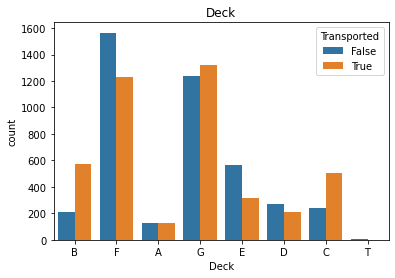

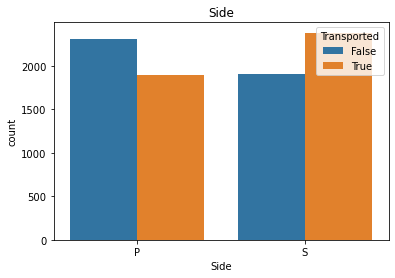

In [14]:
sns.countplot(data=data, x='Deck', hue='Transported').set_title('Deck')
plt.show()
sns.countplot(data=data, x='Side', hue='Transported').set_title('Side')
plt.show()

In [15]:
y = data['Transported']
Pass_id = test['PassengerId']
data.drop(columns=['PassengerId', 'Cabin', 'Name', 'Transported'], inplace=True)
test.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace=True)

In [16]:
total = pd.concat([data, test], axis=0)
total.shape

(12970, 13)

In [17]:
# filling na
data['Age'].fillna(data.Age.median(), inplace=True)
test['Age'].fillna(test.Age.median(), inplace=True)

data['Num'].fillna(data.Num.median(), inplace=True)
test['Num'].fillna(test.Num.median(), inplace=True)

cols = data.columns.drop(['Age', 'Num']).to_list()
print(cols)
for col in cols:
    data[col].fillna(total[col].mode()[0], inplace=True)
    
for col in cols:
    test[col].fillna(total[col].mode()[0], inplace=True)

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side']


In [18]:
# type conversion
data['Num'] = data['Num'].astype('int')
test['Num'] = test['Num'].astype('int')

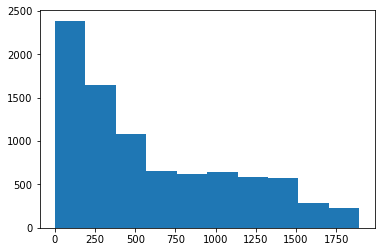

In [19]:
plt.hist(data['Num'])
plt.show()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Deck          8693 non-null   object 
 11  Num           8693 non-null   int64  
 12  Side          8693 non-null   object 
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 764.2+ KB


In [21]:
data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,1,S


In [22]:
total = pd.concat([data, test], axis=0)

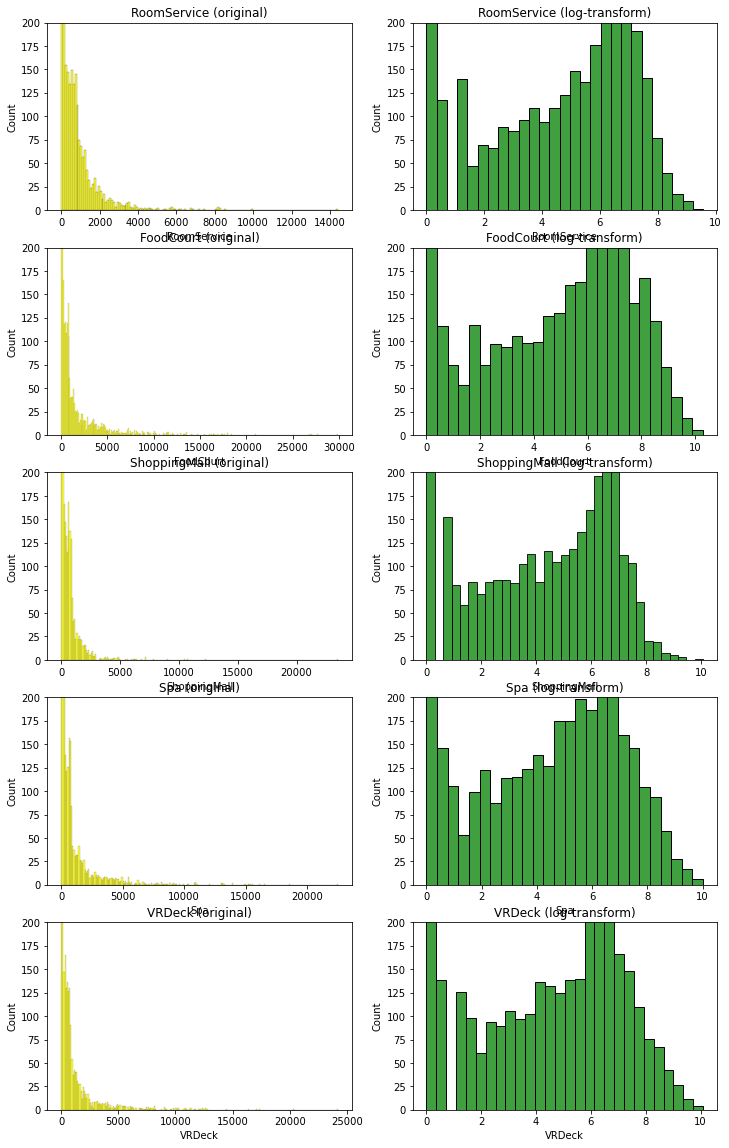

In [23]:
# log transform
fig = plt.figure(figsize=(12, 20))
for i, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    plt.subplot(5, 2, 2*i+1)
    sns.histplot(data[col], binwidth=100,color='yellow')
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(5, 2, 2*i+2)
    sns.histplot(np.log(1+data[col]),color='green')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
plt.show()

In [24]:
# apply log transform
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    total[col] = np.log(1+total[col])

In [25]:
# Encoding and scaling
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num']
categorial_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorial_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', sparse=False))])
ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorial_transformer, categorial_cols)],
        remainder='passthrough')

total = ct.fit_transform(total)

In [26]:
total.shape

(12970, 24)

In [27]:
X_train = total[:len(data)]
X_test = total[len(data):]

In [28]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y,train_size=0.8,test_size=0.2,random_state=0)

In [29]:
# classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), 
    "LGBM" : LGBMClassifier(random_state=0)
}

# grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 6, 8, 10, 12],
        'learning_rate': [0.05, 0.1, 0.15, 0.2]}

grid = {
    "LogisticRegression" : LR_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
}

In [30]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    clf.fit(X_tr, y_tr)
    valid_scores.iloc[i,1] = clf.score(X_val, y_val)
    clf_best_params[key] = clf.best_params_
    
    stop = time.time()
    valid_scores.iloc[i,2] = np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i += 1

Model: LogisticRegression
Training time (mins): 0.05

Model: RandomForest
Training time (mins): 0.28

[18:52:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Model: XGBoost
Training time (mins): 2.21

Model: LGBM
Training time (mins): 0.26



In [31]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.776308,0.05
1,RandomForest,0.807936,0.28
2,XGBoost,0.806210,2.21
3,LGBM,0.803910,0.26


In [32]:
# best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'},
 'RandomForest': {'max_depth': 12, 'n_estimators': 200},
 'XGBoost': {'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 50},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 50}}

In [33]:
best_classifiers = {
    "XGBoost" : XGBClassifier(**clf_best_params["XGBoost"], random_state=0, use_label_encoder=False, eval_metric='logloss'),
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"],random_state=0)
}

In [34]:
folds = 5
preds = np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
    score = 0
    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y)):
        # get training and validation sets
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        # train model
        clf = classifier
        clf.fit(X_tr, y_tr)

        # make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_val, y_val)

    # average accuracy    
    score /= folds

    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print()

# ensemble predictions
preds = preds / (folds*len(best_classifiers))

[18:52:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters a

In [35]:
best_classifier = LGBMClassifier(**clf_best_params["LGBM"],random_state=0)
best_classifier.fit(X_train, y)

LGBMClassifier(max_depth=12, n_estimators=50, random_state=0)

In [36]:
d = {'PassengerId': Pass_id, 'Transported': best_classifier.predict(X_test)}
results = pd.DataFrame(data=d)

In [ ]:
results.to_csv('results.csv', index=False)